<a href="https://colab.research.google.com/github/syyam/COVID-19-Detector-V1.1/blob/master/Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#https://www.biorxiv.org/content/10.1101/2020.07.15.205567v1.full
# https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/#:~:text=The%20LeNet%20architecture%20is%20an,enough%20to%20provide%20interesting%20results.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [11]:
!ls "/content/dr/ive/My Drive/Datasets"
!unrar x "/content/drive/My Drive/Datasets/chest_dataset_xray.rar"

ls: cannot access '/content/dr/ive/My Drive/Datasets': No such file or directory

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/My Drive/Datasets/chest_dataset_xray.rar

Creating    chest_dataset_xray                                        OK
Creating    chest_dataset_xray/Chest_COVID                            OK
Extracting  chest_dataset_xray/Chest_COVID/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg       0%  OK 
Extracting  chest_dataset_xray/Chest_COVID/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg.jpg       0%  OK 
Extracting  chest_dataset_xray/Chest_COVID/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg       0%  OK 
Extracting  chest_dataset_xray/Chest_COVID/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg.jpg       0%  OK 
Extracting  chest_dataset_xray/Chest_COVID/1-s2.0-S0140673620303706-fx1_lrg.jpg       0%  OK 
Extracting  chest_dataset_xray/Chest_COVID/1-s2.0-S0140673620303706-fx1_lrg.jpg.jpg     

In [12]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import cv2
from PIL import Image, ImageFilter

from glob import glob
from tqdm import tqdm_notebook
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K
import matplotlib.pyplot as plt

In [52]:
covid_path = "/content/chest_dataset_xray/Chest_COVID"
non_covid_path = "/content/chest_dataset_xray/Chest_NonCOVID"

In [53]:
covid_dir = glob(covid_path+'/*')
non_covid_dir = glob(non_covid_path+'/*')

In [54]:
covid_labels = []
non_covid_labels = []

covid_images=[]
non_covid_images=[]

In [55]:
for i in range(len(covid_dir)):
    image = cv2.imread(covid_dir[i])
    image = cv2.resize(image,(50,50))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    covid_images.append(image)
    covid_labels.append('Chest_COVID')


for i in range(len(non_covid_dir)):
    image = cv2.imread(non_covid_dir[i])
    image = cv2.resize(image,(50,50))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    non_covid_images.append(image)
    non_covid_labels.append('Chest_NonCOVID')

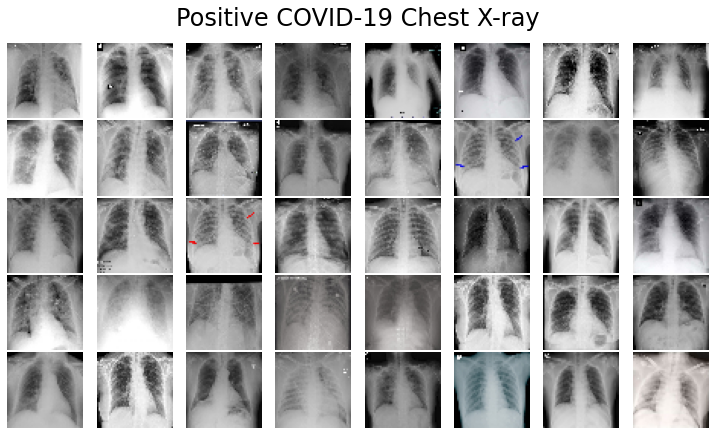

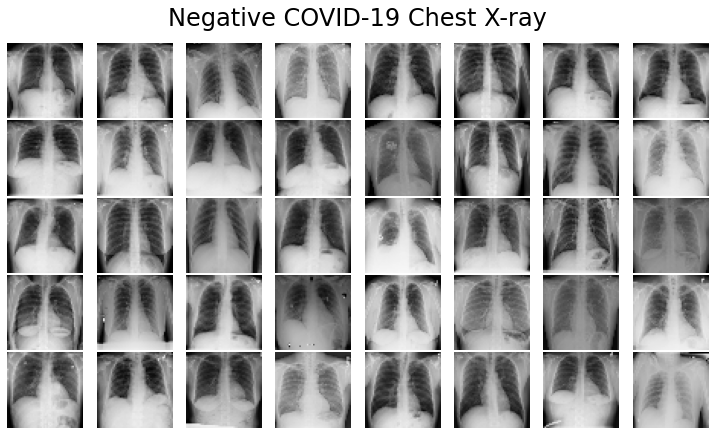

In [56]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(non_covid_images, 'Negative COVID-19 Chest X-ray')

In [57]:
def LeNet_build(numChannels, imgRows, imgCols, numClasses, weightsPath=None):
    # print width, height, depth
    model = Sequential()

    inputShape = (imgRows, imgCols, numChannels)

    # # if we are using "channels first", update the input shape
    # if K.image_data_format() == "channels_first":
    #     inputShape = (numChannels, imgRows, imgCols)
   
    # first set of CONV => RELU => POOL
    model.add(Conv2D(20, (5, 5), padding="same",
        input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # second set of CONV => RELU => POOL
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # set of FullyConnected => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))

    # softmax classifier
    model.add(Dense(numClasses))
    model.add(Activation("sigmoid"))

    # if a weights path is supplied (inicating that the model was
    # pre-trained), then load the weights
    if weightsPath is not None:
        model.load_weights(weightsPath)

    # return the constructed network architecture
    return model

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    non_covid_images, non_covid_labels, test_size=0.2)

X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

In [59]:
# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [62]:
from keras.optimizers import SGD

# initialize the optimizer and model
print("[INFO] compiling model...")
model = LeNet_build(numChannels=3, imgRows= X_train.shape[1], imgCols= X_train.shape[2],numClasses=2) 
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss=['binary_crossentropy'], metrics=['accuracy'])


[INFO] compiling model...


In [64]:
print("[INFO] training...")
history = model.fit(X_train, y_train, epochs=25, batch_size=32)
# show the accuracy on the testing set
print("[INFO] evaluating...")
(loss, accuracy) = model.evaluate(X_test, y_test,
  batch_size=128, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

[INFO] training...
Epoch 1/25
23/23 [==============================] - 4s 193ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 2/25
23/23 [==============================] - 4s 191ms/step - loss: 0.1264 - accuracy: 0.9677
Epoch 3/25
23/23 [==============================] - 4s 190ms/step - loss: 0.0064 - accuracy: 0.9972
Epoch 4/25
23/23 [==============================] - 4s 192ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 5/25
23/23 [==============================] - 4s 192ms/step - loss: 8.1802e-04 - accuracy: 1.0000
Epoch 6/25
23/23 [==============================] - 4s 193ms/step - loss: 0.1462 - accuracy: 0.9677
Epoch 7/25
23/23 [==============================] - 4s 195ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 8/25
23/23 [==============================] - 4s 196ms/step - loss: 5.5630e-04 - accuracy: 1.0000
Epoch 9/25
23/23 [==============================] - 4s 194ms/step - loss: 0.1066 - accuracy: 0.9846
Epoch 10/25
23/23 [==============================] - 4s 194ms/step - loss

In [65]:
# converting model to tflite
savedModel = "exp_saved_model"
tf.saved_model.save(model, savedModel)
converter = tf.lite.TFLiteConverter.from_saved_model(savedModel)
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'
with open(tflite_model_file, 'wb') as f:
  f.write(tflite_model)
model.save('model.h5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: exp_saved_model/assets


In [66]:
m=tf.keras.models.load_model('model.h5')

In [70]:
y_pred = model.predict(X_test)


In [71]:
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))


              precision    recall  f1-score   support

           0       0.95      0.95      0.95        78
           1       0.96      0.96      0.96       101

    accuracy                           0.96       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.96      0.96      0.96       179



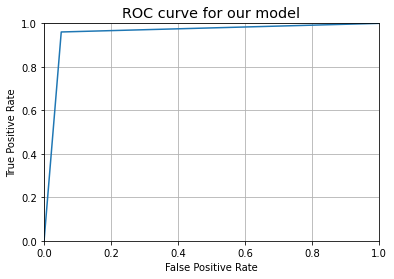

In [73]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Confusion Matrix without Normalization


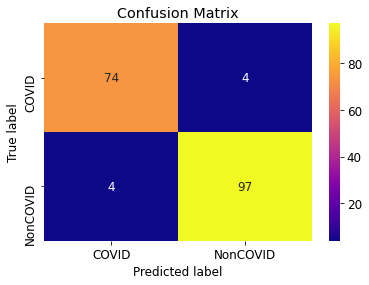

Confusion Matrix with Normalized Values


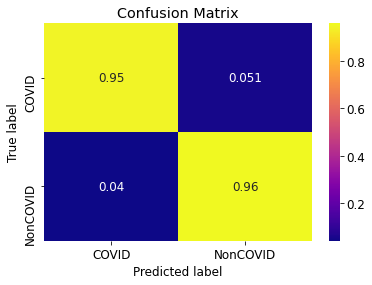

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(normalize):
    classes = ['COVID','NonCOVID']
    tick_marks = [0.5,1.5]
    cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
    sns.heatmap(cn,cmap='plasma',annot=True)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

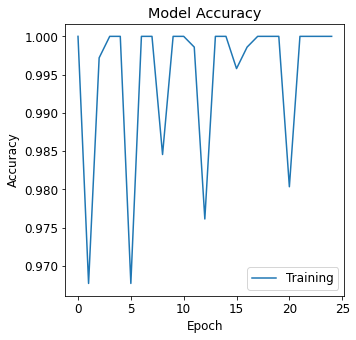

In [77]:
plt.figure(figsize=(5,5))

plt.plot(history.history['accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('mobilenet_accuracy.png')
plt.show()

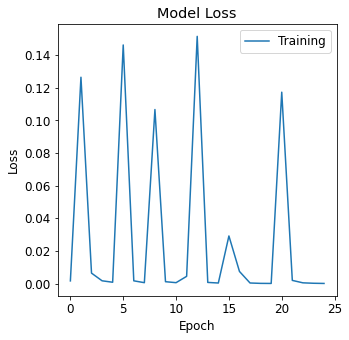

In [78]:

plt.figure(figsize=(5,5))

plt.plot(history.history['loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('mobilenet_loss.png')
plt.show()